In [1]:
from pathlib import Path
import os

In [3]:
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    path = Path('../input/titanic')
    !pip install -Uqq fastai
else:
    import zipfile,kaggle
    path = Path('titanic')
    if not path.exists():
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

In [4]:
from fastai.tabular.all import *

pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

Prep the data

In [5]:
df = pd.read_csv(path/'train.csv')

When you do everything from scratch, every bit of feature engineering requires a whole lot of work, since you have to think about things like dummy variables, normalization, missing values, and so on. But with fastai that's all done for you. 

In [6]:
def add_features(df):
    df['LogFare'] = np.log1p(df['Fare'])
    df['Deck'] = df.Cabin.str[0].map(dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG"))
    df['Family'] = df.SibSp+df.Parch
    df['Alone'] = df.Family==0
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    df['Title'] = df.Title.map(dict(Mr="Mr",Miss="Miss",Mrs="Mrs",Master="Master"))

add_features(df)

In [8]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare,Deck,Family,Alone,TicketFreq,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S,2.11,NaN,1,False,1,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.00,1,0,PC 17599,71.28,C85,C,4.28,ABC,1,False,1,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S,2.19,NaN,0,True,1,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S,3.99,ABC,1,False,2,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S,2.20,NaN,0,True,1,Mr


we can use RandomSplitter to separate out the training and validation sets

In [9]:
splits = RandomSplitter(seed=42)(df)

Now the entire process of getting the data ready for training requires just this one cell!:

In [10]:
dls = TabularPandas(
    df, splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=["Sex","Pclass","Embarked","Deck", "Title"],
    cont_names=['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFreq', 'Family'],
    y_names="Survived", y_block = CategoryBlock(),
).dataloaders(path=".")

C:\Users\vicky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\fastai\tabular\core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)


Train the model

In [11]:
learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])

One handy feature that fastai can also tell us what learning rate to use

SuggestedLRs(slide=0.04786301031708717, valley=0.009120108559727669)

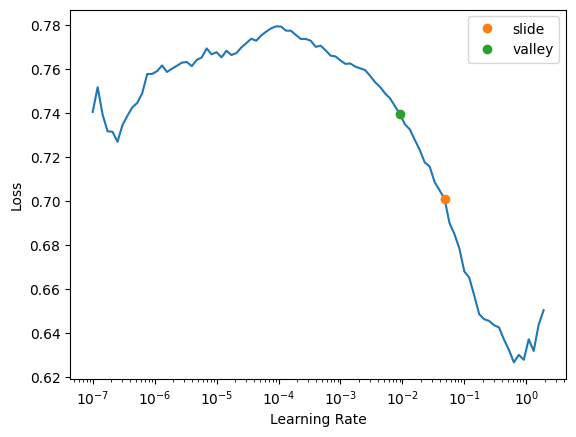

In [12]:
learn.lr_find(suggest_funcs=(slide, valley))

The two colored points are both reasonable choices for a learning rate. I'll pick somewhere between the two (0.03) and train for a few epochs:

In [13]:
learn.fit(16, lr=0.03)

epoch,train_loss,valid_loss,accuracy,time
0,0.547859,0.590293,0.640449,00:00
1,0.508080,0.481418,0.803371,00:00
2,0.469510,0.442730,0.808989,00:00
3,0.449098,0.450369,0.842697,00:00
4,0.417549,0.428384,0.814607,00:00
5,0.415517,0.440584,0.848315,00:00
6,0.401478,0.438075,0.820225,00:00
7,0.396373,0.491749,0.775281,00:00
8,0.401140,0.465741,0.820225,00:00
9,0.392440,0.433571,0.848315,00:00


In [14]:
tst_df = pd.read_csv(path/'test.csv')
tst_df['Fare'] = tst_df.Fare.fillna(0)
add_features(tst_df)

In [15]:
tst_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare,Deck,Family,Alone,TicketFreq,Title
0,892,3,"Kelly, Mr. James",male,34.50,0,0,330911,7.83,NaN,Q,2.18,NaN,0,True,1,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.00,1,0,363272,7.00,NaN,S,2.08,NaN,1,False,1,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.00,0,0,240276,9.69,NaN,Q,2.37,NaN,0,True,1,Mr
3,895,3,"Wirz, Mr. Albert",male,27.00,0,0,315154,8.66,NaN,S,2.27,NaN,0,True,1,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.00,1,1,3101298,12.29,NaN,S,2.59,NaN,2,False,1,Mrs


In [16]:
tst_dl = learn.dls.test_dl(tst_df)

C:\Users\vicky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\fastai\tabular\core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)


In [17]:
preds,_ = learn.get_preds(dl=tst_dl)

In [18]:
tst_df['Survived'] = (preds[:,1]>0.5).int()
sub_df = tst_df[['PassengerId','Survived']]
# sub_df.to_csv('sub.csv', index=False)

In [19]:
sub_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


# Ensembling

Since it's so easy to create a model now, it's easier to play with more advanced modeling approaches. For instance, we can create five separate models, each trained from different random starting points, and average them. This is the simplest approach of ensembling models, which combines multiple models to generate predictions that are better than any of the single models in the ensemble.

To create our ensemble, first we copy the three steps we used above to create and train a model, and apply it to the test set:

In [20]:
def ensemble():
    learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])
    with learn.no_bar(),learn.no_logging(): learn.fit(16, lr=0.03)
    return learn.get_preds(dl=tst_dl)[0]

Now we run this five times, and collect the results into a list:

In [21]:
learns = [ensemble() for _ in range(5)]

We stack this predictions together and take their average predictions:

In [22]:
ens_preds = torch.stack(learns).mean(0)

In [23]:
tst_df['Survived'] = (ens_preds[:,1]>0.5).int()
sub_df = tst_df[['PassengerId','Survived']]

In [24]:
sub_df

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
